# Discrete PPO
This is the implementation of PPO + envpool for discrete action space using image inputs.

## Setup arguments

In [12]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

import time

import numpy as np
import torch

from torch_rl.jupyter_utils import (
    WidgetParser,
    plot_metrics_notebook
)

from torch_rl.utils import (
    seed_everything,
    mp4_to_gif,
    MetricStore,
    SPS
)


parser = WidgetParser()
parser.add_widget(widgets.IntText(
    description='seed',
    value=1,
    tooltip="seed of the experiment"
))

parser.add_widget(widgets.Checkbox(
    description="torch-deterministic",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, `torch.backends.cudnn.deterministic=False`"
))

parser.add_widget(widgets.Checkbox(
    description="cuda",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, cuda will be enabled by default"
))

parser.add_widget(widgets.Checkbox(
    description="capture-video",
    value=False,
    disabled=False,
    indent=False,
    tooltip="whether to capture videos of the agent performances (check out `videos` folder)"
))

parser.add_widget(widgets.Text(
    description="env-id",
    value="Pong-v4",
    tooltip="the id of the environment"
))

parser.add_widget(widgets.IntText(
    description='total-timesteps',
    value=10000000,
    tooltip="total timesteps of the experiments"
))

parser.add_widget(widgets.FloatText(
    description='learning-rate',
    value=2.5e-4,
    tooltip="the learning rate of the optimizer"
))

parser.add_widget(widgets.IntText(
    description='num-envs',
    value=8,
    tooltip="the number of parallel game environments"
))

parser.add_widget(widgets.IntText(
    description='num-steps',
    value=128,
    tooltip="the number of steps to run in each environment per policy rollout"
))

parser.add_widget(widgets.Checkbox(
    description="anneal-lr",
    value=True,
    disabled=False,
    indent=False,
    tooltip="Toggle learning rate annealing for policy and value networks"
))

parser.add_widget(widgets.FloatText(
    description='gamma',
    value=0.99,
    tooltip="the discount factor gamma"
))

parser.add_widget(widgets.FloatText(
    description='gae-lambda',
    value=0.95,
    tooltip="the lambda for the general advantage estimation"
))

parser.add_widget(widgets.IntText(
    description='num-minibatches',
    value=4,
    tooltip="The number of mini-batches"
))

parser.add_widget(widgets.IntText(
    description='update-epochs',
    value=4,
    tooltip="The K epochs to update the policy"
))

parser.add_widget(widgets.Checkbox(
    description="norm-adv",
    value=True,
    disabled=False,
    indent=False,
    tooltip="Toggles advantages normalization"
))

parser.add_widget(widgets.FloatText(
    description='clip-coef',
    value=0.1,
    tooltip="the surrogate clipping coefficient"
))

parser.add_widget(widgets.Checkbox(
    description="clip-vloss",
    value=True,
    disabled=False,
    indent=False,
    tooltip="Toggles whether or not to use a clipped loss for the value function, as per the paper"
))

parser.add_widget(widgets.FloatText(
    description='ent-coef',
    value=0.01,
    tooltip="coefficient of the entropy"
))

parser.add_widget(widgets.FloatText(
    description='vf-coef',
    value=0.5,
    tooltip="coefficient of the value function"
))

parser.add_widget(widgets.FloatText(
    description='max-grad-norm',
    value=0.5,
    tooltip="the maximum norm for the gradient clipping"
))

parser.add_widget(widgets.FloatText(
    description='target-kl',
    value=0,
    tooltip="the target KL divergence threshold"
))

IntText(value=1, description='seed', tooltip='seed of the experiment')

Checkbox(value=True, description='torch-deterministic', indent=False, tooltip='if toggled, `torch.backends.cud…

Checkbox(value=True, description='cuda', indent=False, tooltip='if toggled, cuda will be enabled by default')

Checkbox(value=False, description='capture-video', indent=False, tooltip='whether to capture videos of the age…

Text(value='Pong-v4', description='env-id', tooltip='the id of the environment')

IntText(value=10000000, description='total-timesteps', tooltip='total timesteps of the experiments')

FloatText(value=0.00025, description='learning-rate', tooltip='the learning rate of the optimizer')

IntText(value=8, description='num-envs', tooltip='the number of parallel game environments')

IntText(value=128, description='num-steps', tooltip='the number of steps to run in each environment per policy…

Checkbox(value=True, description='anneal-lr', indent=False, tooltip='Toggle learning rate annealing for policy…

FloatText(value=0.99, description='gamma', tooltip='the discount factor gamma')

FloatText(value=0.95, description='gae-lambda', tooltip='the lambda for the general advantage estimation')

IntText(value=4, description='num-minibatches', tooltip='The number of mini-batches')

IntText(value=4, description='update-epochs', tooltip='The K epochs to update the policy')

Checkbox(value=True, description='norm-adv', indent=False, tooltip='Toggles advantages normalization')

FloatText(value=0.1, description='clip-coef', tooltip='the surrogate clipping coefficient')

Checkbox(value=True, description='clip-vloss', indent=False, tooltip='Toggles whether or not to use a clipped …

FloatText(value=0.01, description='ent-coef', tooltip='coefficient of the entropy')

FloatText(value=0.5, description='vf-coef', tooltip='coefficient of the value function')

FloatText(value=0.5, description='max-grad-norm', tooltip='the maximum norm for the gradient clipping')

FloatText(value=0.0, description='target-kl', tooltip='the target KL divergence threshold')

### Parse inputs

In [14]:
args = parser.parse()
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

run_name = f"{args.env_id}__ppo__{args.seed}__{int(time.time())}"
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
seed_everything(args.seed, args.torch_deterministic)
display(f"using device {device}")

'using device cuda'

## Setup environment

In [15]:
import gym
from torch_rl.atari import (
    NoopResetEnv,
    MaxAndSkipEnv,
    EpisodicLifeEnv,
    ClipRewardEnv,
    FireResetEnv
)


def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

### Ensure environment compatibility

In [16]:
envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

### Environment examples

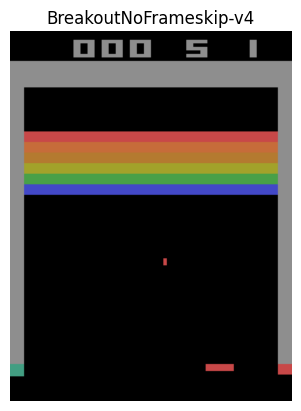

In [17]:
tmp_env = make_env(args.env_id, args.seed, 0, False, None)()
ob = tmp_env.reset()

plt.title(args.env_id)
plt.imshow(tmp_env.render("rgb_array"))
plt.axis('off')
plt.show()

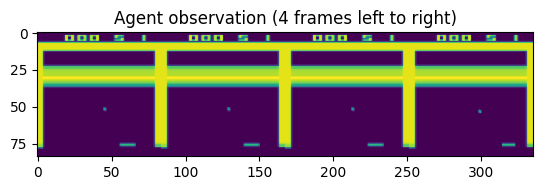

In [18]:
action = tmp_env.action_space.sample()
ob, reward, done, info = tmp_env.step(action)
plt.title("Agent observation (4 frames left to right)")
state_dim = tmp_env.observation_space.shape
plt.imshow(np.array(tmp_env.frames).transpose([0,2,1]).reshape([-1,state_dim[1]]).transpose([1,0]))
plt.show()

In [19]:
action = tmp_env.action_space.sample()
ob, reward, done, info = tmp_env.step(action)
action, ob.shape

(0, (4, 84, 84))

## Modeling

### PPO training Wrapper

In [20]:
from torch_rl.ppo import PPO, PPOTrainingWrapper
agent = PPO(
    envs
).to(device)

wrapper = PPOTrainingWrapper(
    model = agent,
    env=envs,
    device=device
)

### Setup plots

In [21]:
from torch_rl.utils import SPS


def plot_metric(global_step, ms, sps, show_model_metrics=True):
    env_metric_list = ["episodic_return", "episodic_length"]
    model_metric_list = ["value_loss", "policy_loss"]
    env_color_list = ["blue", "black"]
    model_color_list = ["orange", "red"]
    if show_model_metrics:
        metric_list = env_metric_list + model_metric_list
        color_list = env_color_list + model_color_list
    else:
        metric_list = env_metric_list
        color_list = env_color_list

    sps.step(global_step)
    plot_metrics_notebook(ms, metric_list, color_list, sps=sps)


### PPO training loop

99% processed at 514 SPS. Remaining: 11 second(s) 



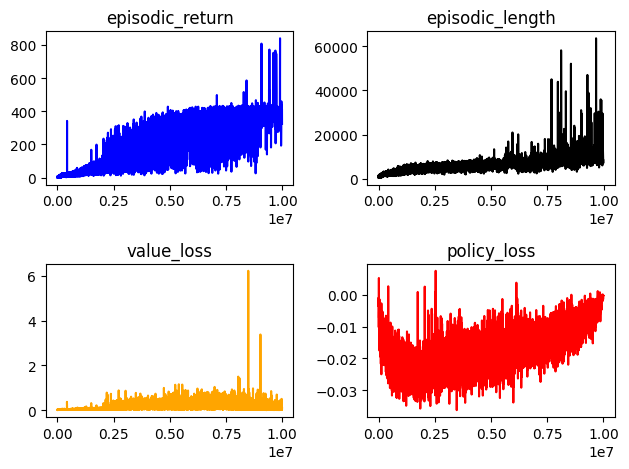

In [22]:
import random
import torch.optim as optim
from collections import deque
from IPython.display import display, clear_output


optimizer = wrapper.get_optimizer(lr=args.learning_rate, eps=1e-5)
ts = wrapper.get_storage(args.num_steps, args.num_envs)

ms = MetricStore()
sps = SPS(args.total_timesteps)

global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)
num_updates = args.total_timesteps // args.batch_size

for update in range(1, num_updates + 1):
    if args.anneal_lr:
        lrnow = wrapper.anneal_lr(args.learning_rate, update, num_updates)
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += 1 * args.num_envs
        ts.obs[step] = next_obs
        ts.dones[step] = next_done

        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            ts.values[step] = value.flatten()
        ts.actions[step] = action
        ts.logprobs[step] = logprob

        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        ts.rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        for idx, d in enumerate(done):
            if d and info[idx]["lives"] == 0:
                ms.log_metric("episodic_return", info[idx]["episode"]["r"], global_step)
                ms.log_metric("episodic_length", info[idx]["episode"]["l"], global_step)

    with torch.no_grad():
        advantages = wrapper.get_advantages(args.num_steps, next_done, next_obs, args.gamma, args.gae_lambda, ts)
        returns = advantages + ts.values

    b_obs = ts.obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = ts.logprobs.reshape(-1)
    b_actions = ts.actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = ts.values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            loss, approx_kl, losses = wrapper.train_step(
                b_obs[mb_inds],
                b_actions.long()[mb_inds],
                b_logprobs[mb_inds],
                b_advantages[mb_inds],
                b_returns[mb_inds],
                b_values[mb_inds],
                args.norm_adv,
                args.clip_coef,
                args.clip_vloss,
                args.ent_coef,
                args.vf_coef
            )

            optimizer.zero_grad()
            loss.backward()
            wrapper.clip_grad_norm(args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and args.target_kl > 0:
            if approx_kl > args.target_kl:
                break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    (pg_loss, v_loss, entropy_loss) = losses

    ms.log_metric("learning_rate", optimizer.param_groups[0]["lr"], global_step)
    ms.log_metric("value_loss", v_loss.item(), global_step)
    ms.log_metric("policy_loss", pg_loss.item(), global_step)
    ms.log_metric("entropy", entropy_loss.item(), global_step)
    ms.log_metric("approx_kl", approx_kl.item(), global_step)
    ms.log_metric("explained_variance", explained_var, global_step)

    if update > 0 and update % 10 == 0:
        global_step = update * args.batch_size
        plot_metric(global_step, ms, sps)


envs.close()

## Evaluation

In [23]:
run_test_name = f"test-{run_name}"
test_env = make_env(args.env_id, args.seed, 0, True, run_test_name)()

ob = test_env.reset()
while True:
    action, _, _, _ = agent.get_action_and_value(ob)
    ob, reward, done, info = test_env.step(action)
    if done:
        print(f'episodic_return={info["episode"]["r"]}, episodic_length={info["episode"]["l"]}')
        break


TypeError: unsupported operand type(s) for /: 'LazyFrames' and 'float'

### Display full evaluation

In [ ]:
mp4_path = f"videos/{run_test_name}/rl-video-episode-0.mp4"
gif_path = f"images/ppo_atari_test.gif"

mp4_to_gif(mp4_path, gif_path)
Image(url=gif_path, width=500, height=500)